### Current Issue 7/10
1. Get more dataset of mental state and validate with 1246_gru_tested.h5
2. Move onto real-time classification with the fully trained model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import mne
import random

from sklearn.model_selection import train_test_split


## Feature extraction method
from scipy import signal
from sklearn.decomposition import FastICA, PCA

### Dataset
Using a person's 3 different mental states, relaxed, neutral, concetrating<br>
- Sampling rate: 256 Hz (256 samples in 1 second period) 
- `trials = 3, channels = 4, samples = 15204 * 0.75, kernels = 1`

#### Demo 1, using a subset of dataset

In [2]:
sub_a_relaxed = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-relaxed-1.csv')
print('sub_a_relaxed shape: {}'.format(sub_a_relaxed.shape))

sub_a_neutral = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-neutral-1.csv')
print('sub_a_neutral shape: {}'.format(sub_a_neutral.shape))

sub_a_concentrating = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-concentrating-1.csv')
print('sub_a_concentrating shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed shape: (15204, 6)
sub_a_neutral shape: (15204, 6)
sub_a_concentrating shape: (15192, 6)


#### Demo 2, using the whole dataset
- Matched the number of samples to 888, the df with the lowest number of rows

In [3]:
directory = os.getcwd() + '/dataset/original_data/'
files = os.listdir(directory)
random.shuffle(files)

data = []
labels = []


for filename in files:
#     if 'subject' in filename:
#         df = pd.read_csv(directory + filename)
#         df = df.drop(columns=['timestamps','Right AUX'])
#         if 'relaxed' in filename:
#             labels.append(0)
#         elif 'neutral' in filename:
#             labels.append(1)
#         elif 'concentrating' in filename:
#             labels.append(2)
#         data.append(df)
        
#         print('{}, shape = ({})'.format(filename, df.shape))
        
    if 'subject' in filename:
        df = pd.read_csv(directory + filename)
        df = df.drop(columns=['timestamps','Right AUX'])
        df = df[:888]
        if 'relaxed' in filename:
            labels.append(0)
        elif 'neutral' in filename:
            labels.append(1)
        elif 'concentrating' in filename:
            labels.append(2)
        data.append(df)
        if len(df) < 15192:
            print('{}, shape = ({})'.format(filename, df.shape))
labels = np.array(labels)

subjectb-concentrating-2.csv, shape = ((888, 4))
subjectd-neutral-1.csv, shape = ((888, 4))
subjectd-concentrating-2.csv, shape = ((888, 4))
subjectc-relaxed-1.csv, shape = ((888, 4))
subjecta-neutral-2.csv, shape = ((888, 4))
subjectd-relaxed-2.csv, shape = ((888, 4))
subjecta-concentrating-1.csv, shape = ((888, 4))
subjectb-neutral-2.csv, shape = ((888, 4))
subjectb-relaxed-2.csv, shape = ((888, 4))
subjectd-concentrating-1.csv, shape = ((888, 4))
subjectd-neutral-2.csv, shape = ((888, 4))
subjectc-relaxed-2.csv, shape = ((888, 4))
subjectb-concentrating-1.csv, shape = ((888, 4))
subjectc-concentrating-2.csv, shape = ((888, 4))
subjectb-neutral-1.csv, shape = ((888, 4))
subjecta-relaxed-2.csv, shape = ((888, 4))
subjectb-relaxed-1.csv, shape = ((888, 4))
subjecta-concentrating-2.csv, shape = ((888, 4))
subjectc-neutral-2.csv, shape = ((888, 4))
subjecta-neutral-1.csv, shape = ((888, 4))
subjectd-relaxed-1.csv, shape = ((888, 4))
subjectc-neutral-1.csv, shape = ((888, 4))
subjecta-rel

In [8]:
data = np.array([np.transpose(df) for df in data])
print(data.shape)
data

(24, 4, 888)


array([[[  -6.348,  -12.207,    1.953, ...,   -2.441,   -2.93 ,
          -11.719],
        [  51.758,   55.664,   49.805, ...,   25.879,   26.855,
           26.367],
        [ -24.414,  -65.918,   61.523, ...,   73.242, -105.957,
         -112.305],
        [   4.395,    3.906,    8.789, ...,   -5.859,   -5.371,
           -5.859]],

       [[  40.527,   39.062,   29.297, ...,   59.57 ,   54.688,
           38.574],
        [  39.062,   33.691,   35.645, ...,   41.016,   39.062,
           36.133],
        [  10.742,    1.465,   -2.93 , ...,   50.293,   33.203,
           19.531],
        [  31.738,   36.133,   31.25 , ...,   41.504,   46.387,
           35.645]],

       [[  20.508,   -1.465,   -0.977, ...,   17.09 ,   19.531,
           -0.488],
        [  12.207,   15.625,   15.625, ...,   16.602,   16.602,
           11.719],
        [  25.391,   35.156,   36.133, ...,   15.625,   17.578,
           13.184],
        [  11.23 ,   -0.488,    4.883, ...,    5.371,   10.742,
        

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [9]:
labels

array([2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1,
       0, 0])

### Preprocessing
- Convert data to NHWC (trials, channels, samples, kernels) format

#### Data Cleaning
- Drop unnecessary columns = `['timestamps','Right AUX']`
- Match the number of samples = `15192`

In [29]:
sub_a_relaxed = sub_a_relaxed.drop(columns=['timestamps','Right AUX'])
sub_a_neutral = sub_a_neutral.drop(columns=['timestamps','Right AUX'])
sub_a_concentrating = sub_a_concentrating.drop(columns=['timestamps','Right AUX'])

In [15]:
sub_a_relaxed = sub_a_relaxed[:15192]
sub_a_neutral = sub_a_neutral[:15192]

print('sub_a_relaxed\' shape: {}'.format(sub_a_relaxed.shape))
print('sub_a_neutral\' shape: {}'.format(sub_a_neutral.shape))
print('sub_a_concentrating\' shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed' shape: (15192, 4)
sub_a_neutral' shape: (15192, 4)
sub_a_concentrating' shape: (15192, 4)


In [24]:
X = np.array([np.transpose(sub_a_relaxed), np.transpose(sub_a_neutral), np.transpose(sub_a_concentrating)])
print(X.shape)
X

(3, 4, 15192)


array([[[ 30.762,  26.367,  21.484, ...,  21.484,  20.996,  33.203],
        [ 15.625,  13.672,  14.16 , ...,  22.949,  21.973,  22.461],
        [ 29.785,  28.32 ,  28.32 , ...,  34.18 ,  33.691,  31.738],
        [  0.977,   0.   ,   2.93 , ...,  11.23 ,   5.859,  10.254]],

       [[  4.883,  19.531,  20.508, ...,  34.668,  35.156,  20.02 ],
        [ 22.949,  22.461,  19.531, ...,  33.203,  32.715,  30.273],
        [  8.789,   5.371,  11.23 , ...,  16.602,  18.555,  10.254],
        [ 23.926,  28.32 ,  25.391, ...,  25.391,  35.156,  18.555]],

       [[ 59.105,  62.012,  44.922, ...,  48.828,  50.293,  45.41 ],
        [ 28.32 ,  30.273,  30.273, ...,  31.25 ,  31.25 ,  30.273],
        [ 15.137,  43.945, -97.656, ..., 258.789, 264.16 ,  27.344],
        [ 12.207,  11.719,  11.23 , ...,  38.086,  39.551,  39.062]]])

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [28]:
Y = np.array([0.0, 1.0, 2.0])
print(Y.shape)
Y

(3,)


array([0., 1., 2.])

### Feature Extraction - Denoising
Fast Fourier Transform (FFT) - A method to remove the artifact from the recorded data, such as eye blinks

[ 0.00000000e+00  6.57721652e-05  1.31544330e-04 ... -1.97316496e-04
 -1.31544330e-04 -6.57721652e-05]


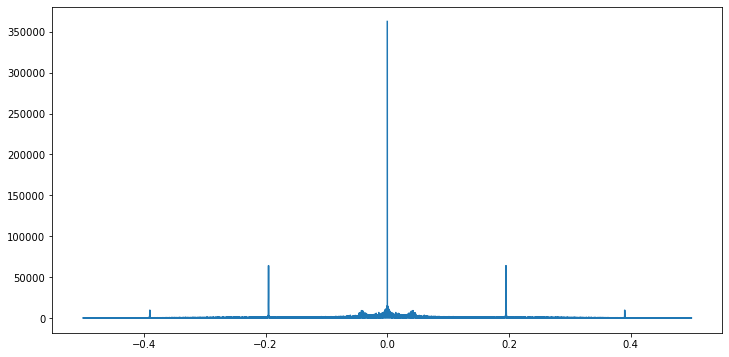

In [26]:
import numpy.fft as fft
n = sub_a_relaxed.shape[0]
spectrum = fft.fft(sub_a_relaxed['TP9'], n)
freq = fft.fftfreq(len(spectrum))
print(freq)
plt.figure(figsize=(12,6))
plt.plot(freq, abs(spectrum))

In [ ]:
n = sub_a_relaxed.shape[0]
fhat = fft.fft(sub_a_relaxed['TP9'], n)
freq = fhat * np.conj(fhat) / n
L = np.arrange(1, np.floor(n/2), dtype='int')


# plt.figure(figsize=(12,6))
# plt.plot(freq, abs(spectrum))

In [32]:
points_per_freq = len(freq) / (257 / 2)
points_per_freq`

118.31906614785993

### Model - EEGNet (Proven to be effective in classifying EEG Data)
Parameter settings so far: nb_classes=3, as there are 3 classes to classify: relaxed, neutral, concentrating<br>

Paper - https://arxiv.org/pdf/1611.08024.pdf <br>
Github - https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py <br>

### First Demo with 15192 samples (1 min period of mental state)

In [78]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=4, Samples=X.shape[2],
                dropoutRate = 0.5, kernLength=int(X.shape[2]/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 15192, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 15192, 8)       60768     
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 15192, 8)       32        
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 1, 15192, 16)      64        
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 15192, 16)      64        
_________________________________________________________________
activation_8 (Activation)    (None, 1, 15192, 16)      0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 3798, 16)       0   

In [64]:
X_train = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_train.shape

(3, 4, 15192, 1)

In [79]:
model.fit(X_train, Y_train, batch_size = 128, epochs=5)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 1.2772 - accuracy: 0.6667
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 0.7128 - accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 0.2945 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 0.1381 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 0.0612 - accuracy: 1.0000


In [94]:
# Using as a test dataset
sub_b_relaxed = pd.read_csv(os.getcwd() + '/dataset/original_data/subjectb-relaxed-1.csv')
sub_b_relaxed = sub_b_relaxed.drop(columns=['timestamps','Right AUX'])
sub_b_relaxed = sub_b_relaxed[:15192]
print('sub_b_relaxed shape: {}'.format(sub_b_relaxed.shape))

sub_b_relaxed shape: (15192, 4)


In [95]:
X_test = np.array([np.transpose(sub_b_relaxed)])
print(X_test.shape)
X_test

(1, 4, 15192)


array([[[ 43.457,  57.617,  41.504, ...,  17.09 ,  21.973,  47.363],
        [ 39.551,  40.039,  41.016, ...,  22.949,  30.762,  35.156],
        [ 48.828,  48.34 ,  47.852, ...,  22.949,  20.508,  27.832],
        [ 19.043,  23.438,  25.879, ..., -19.043, -20.508, -13.672]]])

In [96]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test.shape

(1, 4, 15192, 1)

In [119]:
Y_test = np.array([0])
print(Y_test.shape)
Y_test

(1,)


array([0])

In [120]:
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print(Y_test.shape)
Y_test

(1, 3)


array([[1., 0., 0.]], dtype=float32)

In [102]:
probs = model.predict(X_test)
probs

array([[0.10493065, 0.13374467, 0.7613246 ]], dtype=float32)

In [100]:
preds = probs.argmax(axis = -1)  
preds

array([2], dtype=int64)

In [121]:
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.000000 


In [81]:
model.save('suba-1_checkpoint.h5')

### Second Demo
Using the raw dataset

In [4]:
kernels, chans, samples = 1, 4, 888

In [5]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=chans, Samples=samples,
                dropoutRate = 0.5, kernLength=int(samples/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 888, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 888, 8)         3552      
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 888, 8)         32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 888, 16)        64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 888, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 888, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 222, 16)        0     

In [10]:
X_train = data[:18]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('X_train.shape = {}'.format(X_train.shape))

X_test = data[18:21]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('X_test.shape = {}'.format(X_test.shape))

X_val = data[21:24]
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
print('X_val.shape = {}'.format(X_val.shape))

X_train.shape = (18, 4, 888, 1)
X_test.shape = (3, 4, 888, 1)
X_val.shape = (3, 4, 888, 1)


In [11]:
labels

array([2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1,
       0, 0])

In [12]:
from tensorflow.keras import utils as np_utils
Y_train = labels[:18]
Y_train = np_utils.to_categorical(Y_train, num_classes=3)
print('Y_train.shape = {}'.format(Y_train.shape))


Y_test = labels[18:21]
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print('Y_test.shape = {}'.format(Y_test.shape))

Y_val = labels[21:24]
Y_val = np_utils.to_categorical(Y_val, num_classes=3)
print('Y_val.shape = {}'.format(Y_val.shape))

Y_train.shape = (18, 3)
Y_test.shape = (3, 3)
Y_val.shape = (3, 3)


In [13]:
model.fit(X_train, Y_train, batch_size = 16, epochs=100,
         verbose = 2, validation_data=(X_val, Y_val))

Epoch 1/100
2/2 - 4s - loss: 1.6711 - accuracy: 0.4444 - val_loss: 1.1448 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 - 0s - loss: 1.0666 - accuracy: 0.3333 - val_loss: 1.1340 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 - 0s - loss: 1.0026 - accuracy: 0.5556 - val_loss: 1.1328 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 - 0s - loss: 0.9637 - accuracy: 0.5000 - val_loss: 1.1355 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 - 0s - loss: 0.9671 - accuracy: 0.4444 - val_loss: 1.1349 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 - 0s - loss: 0.9488 - accuracy: 0.6111 - val_loss: 1.1358 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 - 0s - loss: 0.9182 - accuracy: 0.6667 - val_loss: 1.1316 - val_accuracy: 0.0000e+00
Epoch 8/100
2/2 - 0s - loss: 0.8342 - accuracy: 0.7222 - val_loss: 1.1272 - val_accuracy: 0.3333
Epoch 9/100
2/2 - 0s - loss: 0.8892 - accuracy: 0.6667 - val_loss: 1.1221 - val_accuracy: 0.3333
Epoch 10/100
2/2 - 0s - loss: 0.8694 - accuracy: 0.6667 - val_loss: 1.1178 - val_accuracy: 0.3333
E

Epoch 85/100
2/2 - 0s - loss: 0.3467 - accuracy: 1.0000 - val_loss: 1.1475 - val_accuracy: 0.3333
Epoch 86/100
2/2 - 0s - loss: 0.3438 - accuracy: 1.0000 - val_loss: 1.1473 - val_accuracy: 0.3333
Epoch 87/100
2/2 - 0s - loss: 0.3564 - accuracy: 1.0000 - val_loss: 1.1415 - val_accuracy: 0.3333
Epoch 88/100
2/2 - 0s - loss: 0.3406 - accuracy: 1.0000 - val_loss: 1.1252 - val_accuracy: 0.3333
Epoch 89/100
2/2 - 0s - loss: 0.3453 - accuracy: 1.0000 - val_loss: 1.1208 - val_accuracy: 0.3333
Epoch 90/100
2/2 - 0s - loss: 0.3502 - accuracy: 1.0000 - val_loss: 1.1319 - val_accuracy: 0.3333
Epoch 91/100
2/2 - 0s - loss: 0.3779 - accuracy: 1.0000 - val_loss: 1.1503 - val_accuracy: 0.3333
Epoch 92/100
2/2 - 0s - loss: 0.3296 - accuracy: 1.0000 - val_loss: 1.1588 - val_accuracy: 0.3333
Epoch 93/100
2/2 - 0s - loss: 0.3706 - accuracy: 0.9444 - val_loss: 1.1587 - val_accuracy: 0.3333
Epoch 94/100
2/2 - 0s - loss: 0.3619 - accuracy: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.3333
Epoch 95/100
2/2 - 0

In [16]:
probs       = model.predict(X_val)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_val.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.333333 


### Third Demo
Using the feature extracted dataset

In [38]:
mental_state = pd.read_csv("mental-state.csv")

print('mental_state shape: {}'.format(mental_state.shape))
mental_state

mental_state shape: (2479, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,15.762328,19.113555,23.696867,7.568395,-6.503336,6.867187,-11.955396,-16.519912,19.838319,14.333094,...,0.008537,0.008941,0.004102,0.003156,0.003659,0.010179,0.004591,0.013817,0.004536,0.0
2475,34.675582,34.200645,-57.624820,-4.825609,7.382353,2.324416,-1.341208,-4.178625,26.383597,28.782987,...,0.003324,0.003593,0.001702,0.003121,0.002686,0.001645,0.001770,0.001038,0.001973,2.0
2476,29.813809,29.623031,-86.503988,7.532121,-19.581287,-0.628400,133.947160,-2.049096,45.484851,32.163999,...,0.000754,0.000508,0.000263,0.000701,0.000797,0.001096,0.000388,0.000529,0.001079,2.0
2477,59.453973,17.944332,-10.164238,42.568211,-1.300655,-19.993690,-54.331696,12.947622,55.203380,40.228490,...,0.003332,0.003557,0.004063,0.001662,0.002665,0.002353,0.003976,0.001660,0.003229,2.0


In [39]:
mental_state['Label'].value_counts()

1.0    830
2.0    830
0.0    819
Name: Label, dtype: int64

In [40]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocess_inputs(mental_state)

In [42]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model_989 = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
model_989.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model_989.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
44/44 [==============================] - 197s 4s/step - loss: 5.3855 - accuracy: 0.6119 - val_loss: 0.8193 - val_accuracy: 0.8444
Epoch 2/20
44/44 [==============================] - 197s 4s/step - loss: 0.5102 - accuracy: 0.8887 - val_loss: 0.5470 - val_accuracy: 0.8905
Epoch 3/20
44/44 [==============================] - 198s 5s/step - loss: 0.1434 - accuracy: 0.9469 - val_loss: 0.4480 - val_accuracy: 0.9193
Epoch 4/20
44/44 [==============================] - 192s 4s/step - loss: 0.1646 - accuracy: 0.9464 - val_loss: 0.6178 - val_accuracy: 0.9078
Epoch 5/20
44/44 [==============================] - 196s 4s/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.4044 - val_accuracy: 0.9280
Epoch 6/20
44/44 [==============================] - 171s 4s/step - loss: 0.0332 - accuracy: 0.9860 - val_loss: 0.4706 - val_accuracy: 0.9164
Epoch 7/20
44/44 [==============================] - 157s 4s/step - loss: 0.0365 - accuracy: 0.9859 - val_loss: 0.6989 - val_accuracy: 0.8761
Epoch 8/20
44

In [44]:
model_acc = model_989.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 94.758%


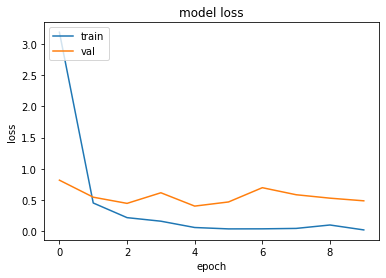

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

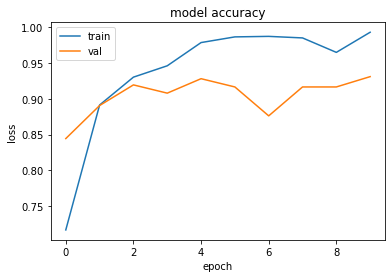

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}

In [46]:
X_test

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3
2412,21.533953,24.349250,14.263184,19.638066,-1.596033,-2.303877,7.172422,-2.758178,27.777065,27.413900,...,0.006086,0.007197,0.012766,0.008290,0.011961,0.004939,0.022888,0.006256,0.008407,0.007981
792,13.854969,30.963898,86.671848,10.726926,11.014309,-2.351598,-96.565275,5.507241,7.679991,35.161736,...,0.013451,0.005752,0.010372,0.001696,0.017567,0.010390,0.005568,0.005870,0.003657,0.010142
564,92.313766,-27.812984,-33.092516,69.694520,37.149972,70.093665,257.544227,24.399168,90.861099,-49.892207,...,0.000166,0.000828,0.002567,0.000455,0.001419,0.004096,0.002097,0.001676,0.001924,0.000989
1728,20.242703,33.720023,33.735270,24.385453,2.376185,66.385647,9.040695,-9.018088,11.874386,-8.302259,...,0.003197,0.001923,0.000472,0.003554,0.004350,0.001391,0.003987,0.001525,0.004844,0.003821
1034,36.272039,27.124422,-33.611277,21.467242,-2.740810,1.210147,-2.092335,-5.686588,36.508013,25.270959,...,0.002429,0.001517,0.000897,0.000466,0.000372,0.001456,0.000588,0.000391,0.000921,0.000721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,38.717262,35.903930,30.488977,38.679148,-6.559766,-3.534145,-23.642179,-6.966519,35.499137,36.703360,...,0.009700,0.007417,0.009890,0.007237,0.005449,0.002260,0.002470,0.006113,0.006091,0.003284
1059,53.167348,29.899617,-53.899781,37.067426,-31.999664,-6.244550,-10.205804,-30.779264,93.524951,37.682383,...,0.000721,0.002283,0.000670,0.001303,0.000687,0.000899,0.001852,0.000705,0.001225,0.000572
2434,27.872078,27.441035,30.076984,23.603434,1.334606,-4.799774,30.758425,11.939336,30.805420,28.823100,...,0.006328,0.010904,0.018422,0.002817,0.006737,0.018157,0.007096,0.001726,0.012838,0.014391
15,23.331109,27.687673,86.342198,20.713019,-3.626738,3.980956,102.890579,2.351927,28.806945,24.416551,...,0.000572,0.000563,0.000393,0.001054,0.000611,0.000548,0.000535,0.000593,0.000752,0.000922


In [47]:
y_test

2412    0.0
792     1.0
564     2.0
1728    2.0
1034    2.0
       ... 
1935    2.0
1059    2.0
2434    1.0
15      1.0
1204    1.0
Name: Label, Length: 744, dtype: float64

In [49]:
model_989.predict(X_test)

array([[9.9963522e-01, 3.6465641e-04, 1.6611828e-07],
       [1.9576350e-07, 9.9999917e-01, 6.0598194e-07],
       [4.1574369e-10, 1.7011987e-09, 1.0000000e+00],
       ...,
       [1.1131902e-05, 9.9889958e-01, 1.0892919e-03],
       [4.8530450e-11, 9.7265673e-01, 2.7343281e-02],
       [7.3799286e-03, 9.9261403e-01, 6.0753728e-06]], dtype=float32)

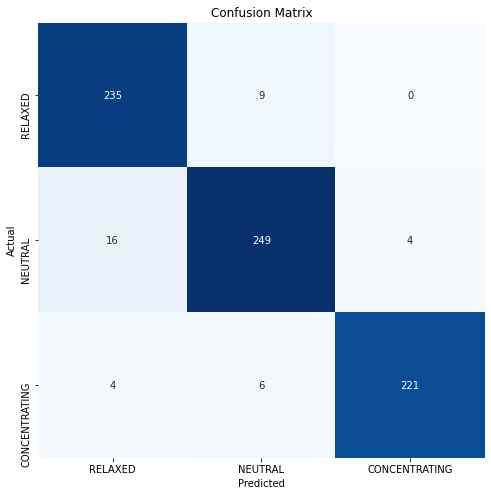

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.92      0.96      0.94       244
      NEUTRAL       0.94      0.93      0.93       269
CONCENTRATING       0.98      0.96      0.97       231

     accuracy                           0.95       744
    macro avg       0.95      0.95      0.95       744
 weighted avg       0.95      0.95      0.95       744



In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.array(list(map(lambda x: np.argmax(x), model_989.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [52]:
model_989.save('989_gru.h5')

### Generating new csv from github dataset

In [15]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

path = os.getcwd() + '/dataset/original_data'
print(path)
mat = gen_training_matrix(path, 'mind_wandering', [])
mat

C:\Users\14056\Desktop\EEG_Classification/dataset/original_data
name-concentrating-1
name
concentrating
Using file name-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-1
subjecta
concentrating
Using file subjecta-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv
resulting vector shape for the file (102, 1246)
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (116, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (117, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (116, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (116, 1246)
subjectb-concentrating-1
subjectb
concentrating
Using file subjectb-

In [23]:
mind_wandering = pd.read_csv('mind_wandering')
print(mind_wandering.shape)
mind_wandering

(2479, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,16.481383,15.838645,20.923613,3.868094,17.375938,1.753072,2.773070,1.560500,15.067953,-2.449311,...,0.085100,0.064925,0.031733,0.050842,0.074206,0.124876,0.018076,0.060481,0.057522,0.0
1,23.733152,28.509188,27.360910,-9.843813,25.695789,0.575784,4.896850,-12.705741,3.139401,3.876334,...,0.030827,0.041627,0.038336,0.013650,0.023462,0.047628,0.043392,0.064315,0.024526,0.0
2,21.083816,19.895562,18.968566,20.132062,24.353063,8.458956,-6.960552,8.420081,13.663810,2.692684,...,0.053886,0.036274,0.035740,0.038103,0.049851,0.015408,0.060786,0.064373,0.020419,1.0
3,3.253930,25.844574,79.116809,8.342746,20.599352,-2.702003,-0.594606,-38.274286,-2.628310,-5.524813,...,0.036960,0.046494,0.057281,0.058323,0.043862,0.053333,0.087944,0.013122,0.033914,0.0
4,32.979984,35.343152,-129.270523,25.274320,21.945969,4.657734,2.249219,-69.488195,-0.203635,-0.735726,...,0.005689,0.005457,0.001655,0.005883,0.004656,0.004733,0.004073,0.005072,0.005622,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,24.408328,25.667238,30.307758,24.299613,22.199598,0.946822,-2.385283,-5.065522,-2.195507,4.632400,...,0.060562,0.050219,0.028050,0.037710,0.058077,0.046329,0.034661,0.073741,0.079413,0.0
2475,24.288141,21.467258,29.664977,12.277609,26.782973,-2.271717,2.137290,-2.571791,0.258334,3.943137,...,0.110801,0.048037,0.030653,0.051616,0.046190,0.051400,0.040910,0.025646,0.032765,0.0
2476,16.386016,25.449730,27.654664,10.263465,26.906937,-11.676210,3.265842,-1.749670,-15.211361,0.561848,...,0.060503,0.056769,0.016124,0.029197,0.031900,0.073301,0.015888,0.002436,0.035329,1.0
2477,22.987340,24.354957,24.288199,17.356859,24.240461,-0.552771,3.836906,37.554667,-1.576095,-4.530965,...,0.049001,0.083742,0.012564,0.034685,0.037678,0.022842,0.018358,0.011174,0.042973,0.0


In [24]:
mind_wandering['Label'].value_counts()

2.0    830
1.0    830
0.0    819
Name: Label, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = preprocess_inputs(mind_wandering)

In [28]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
44/44 [==============================] - 190s 4s/step - loss: 6.0749 - accuracy: 0.5948 - val_loss: 1.0480 - val_accuracy: 0.8271
Epoch 2/20
44/44 [==============================] - 169s 4s/step - loss: 0.5377 - accuracy: 0.8867 - val_loss: 0.9000 - val_accuracy: 0.8415
Epoch 3/20
44/44 [==============================] - 172s 4s/step - loss: 0.2303 - accuracy: 0.9393 - val_loss: 0.4307 - val_accuracy: 0.9020
Epoch 4/20
44/44 [==============================] - 173s 4s/step - loss: 0.1589 - accuracy: 0.9595 - val_loss: 0.5964 - val_accuracy: 0.9020
Epoch 5/20
44/44 [==============================] - 173s 4s/step - loss: 0.0635 - accuracy: 0.9790 - val_loss: 0.3899 - val_accuracy: 0.9366
Epoch 6/20
44/44 [==============================] - 180s 4s/step - loss: 0.0191 - accuracy: 0.9935 - val_loss: 0.5941 - val_accuracy: 0.9395
Epoch 7/20
44/44 [==============================] - 206s 5s/step - loss: 0.1160 - accuracy: 0.9719 - val_loss: 0.4299 - val_accuracy: 0.9020
Epoch 8/20
44

In [30]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 92.742%


In [32]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}

In [33]:
X_test

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_659_4,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4
2412,25.424973,-17.614375,32.493598,21.865875,29.127141,-18.878153,0.489474,16.780905,-2.257252,-4.993806,...,0.005472,0.013660,0.031179,0.024357,0.028514,0.034570,0.014269,0.045188,0.016358,0.022625
792,15.718484,115.821867,-579.490660,12.979508,24.660113,19.649232,-170.145955,720.924986,28.940793,-2.088506,...,0.004709,0.002905,0.002722,0.002205,0.006307,0.002322,0.005463,0.001628,0.002900,0.004544
564,30.364977,46.558379,-26.126867,17.023105,23.008359,14.767124,0.064933,37.776384,4.238803,-0.476757,...,0.003072,0.010312,0.012050,0.022987,0.014199,0.005947,0.012387,0.010299,0.002835,0.000672
1728,27.496336,20.496406,31.045867,-3.162359,24.070746,-8.435205,2.915673,-3.596188,-13.659502,-2.054757,...,0.067564,0.026157,0.049743,0.067106,0.037596,0.029957,0.052189,0.070352,0.057723,0.006037
1034,19.062039,21.963160,32.930387,13.996117,27.780520,-16.266509,2.341476,8.174973,-6.269097,4.000325,...,0.040791,0.032998,0.035613,0.027868,0.089029,0.066754,0.087388,0.020152,0.050728,0.065582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,32.642367,29.186234,56.669238,22.665027,22.583023,59.786704,12.293798,-20.877694,59.814028,-3.487232,...,0.009657,0.003790,0.016537,0.012653,0.017528,0.011030,0.007071,0.003956,0.009225,0.007511
1059,40.023809,35.621648,-62.879543,-4.518492,24.913797,3.340981,0.509492,-8.996983,4.844432,-1.288017,...,0.016422,0.047934,0.024865,0.034611,0.018285,0.013902,0.006733,0.020504,0.032040,0.008336
2434,35.188715,32.291406,-69.272988,-0.820188,24.852734,-8.261413,-0.207049,9.248070,-1.986913,5.773653,...,0.022761,0.027900,0.023723,0.036557,0.022434,0.008206,0.001881,0.024254,0.038976,0.009429
15,17.370262,-0.471125,32.270395,9.672199,24.974848,2.655548,33.326193,-17.298875,-22.121268,-3.426928,...,0.034116,0.019738,0.013782,0.023540,0.014592,0.012901,0.023984,0.027613,0.017700,0.012127


In [34]:
y_test

2412    2.0
792     1.0
564     2.0
1728    1.0
1034    1.0
       ... 
1935    2.0
1059    2.0
2434    2.0
15      2.0
1204    1.0
Name: Label, Length: 744, dtype: float64

In [35]:
model.predict(X_test)

array([[5.3899962e-13, 5.4883975e-12, 1.0000000e+00],
       [3.4665548e-13, 1.5631734e-08, 1.0000000e+00],
       [3.3761520e-21, 1.1045016e-18, 1.0000000e+00],
       ...,
       [1.7209749e-18, 1.1452423e-15, 1.0000000e+00],
       [2.6929051e-02, 1.6508151e-06, 9.7306937e-01],
       [3.3333433e-11, 1.0000000e+00, 3.3385221e-15]], dtype=float32)

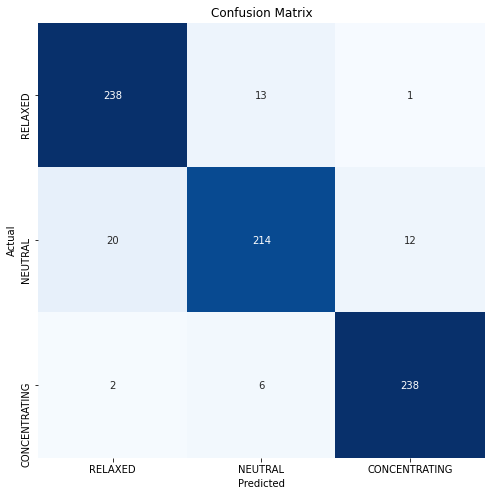

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.92      0.94      0.93       252
      NEUTRAL       0.92      0.87      0.89       246
CONCENTRATING       0.95      0.97      0.96       246

     accuracy                           0.93       744
    macro avg       0.93      0.93      0.93       744
 weighted avg       0.93      0.93      0.93       744



In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [37]:
model.save('1246_gru.h5')

### Validating over my collected data (7/10)
1. Reformat the timestamp (÷ 1,000,000) that period of 1.0 can actually represent 1 second in the timestamp of the dataset (currently 1,000,000 represents one second period)
2. Export the new dataset into my_new_data
3. Perform feature extraction over my_new_data folder

In [113]:
def reformat_timestamp_n_export(raw_dir, new_dir):
    
    # ~/new_dataset
    if not os.getcwd() + '/new_dataset':
        os.mkdir('/new_dataset')
        
    # ~/new_dataset/filename        
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    files = os.listdir(raw_dir)
    for file in files:
        if '.csv' in file:
            print(file)
            df = pd.read_csv(raw_dir + '/' + file)
            for i in range(df['timestamps'].shape[0]):
                timestamp = df['timestamps'][i]/1000000.0
                df['timestamps'][i] = timestamp
            df.to_csv(new_dir + '/' + file, index=False)

In [115]:
def new_dataset(filename):
    
    raw_dir = os.getcwd() + '/raw_dataset/' + filename
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

    print(raw_dir)
    print(new_dir)
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    

new_dataset('mental-state')

/Users/andyko/Desktop/EEG_Classification/raw_dataset/mental-state
/Users/andyko/Desktop/EEG_Classification/new_dataset/mental-state
subjecta-concentrating-1.csv
subjecta-relaxed-1.csv
subjecta-neutral-1.csv
subjectb-neutral-1.csv


In [5]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'mental-state'
raw_dir = os.getcwd() + '/raw_dataset/' + filename
new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

print('new_dir: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/mental-state-test.csv'

gen_training_matrix(new_dir, outfile_path, [])

new_dir: C:\Users\14056\Desktop\EEG_Classification/new_dataset/mental-state
subjecta-concentrating-1
subjecta
concentrating
Using file subjecta-concentrating-1.csv
resulting vector shape for the file (233, 1246)
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (84, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (72, 1246)
subjectb-neutral-1
subjectb
neutral
Using file subjectb-neutral-1.csv
resulting vector shape for the file (77, 1246)
FINAL_MATRIX (466, 1246)


In [6]:
outfile_path = os.getcwd() + '/final_dataset/mental-state-test.csv'
mental_state_test = pd.read_csv(outfile_path)
print(mental_state_test.shape)
mental_state_test

(466, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-32.835012,-29.756555,-30.616777,-22.864500,1.0,4.226164,3.272177,1.113522,5.079928,0.0,...,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,0.000000e+00,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00,0.0
1,-34.004223,-31.633387,-30.490902,-27.353816,1.0,-1.264217,-1.762242,1.005284,-2.336440,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
2,-31.890855,-29.411324,-27.668023,-22.442930,1.0,-2.517530,1.160086,-1.470060,-1.838488,0.0,...,4.428933e-19,3.569605e-19,3.557783e-19,4.385062e-19,0.000000e+00,4.365796e-19,3.526575e-19,3.522706e-19,4.351439e-19,2.0
3,-26.618988,-21.490086,-11.682508,-25.004465,1.0,-12.489235,3.382499,0.909437,13.872704,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.749779e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
4,-30.618672,-27.811039,-28.177250,-25.095496,1.0,-8.495357,-5.197282,0.154096,-7.354144,0.0,...,8.857867e-19,7.139210e-19,7.115566e-19,8.770125e-19,0.000000e+00,8.731593e-19,7.053150e-19,7.045412e-19,8.702878e-19,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,-39.823535,-22.712707,-22.434262,-22.781309,1.0,-5.746433,0.571058,-1.886656,19.621902,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.999118e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
462,-27.456258,-32.295211,-30.439395,-17.922121,1.0,0.230727,0.664401,0.077608,-2.692824,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
463,-31.406418,-28.295527,-29.029816,-11.582398,1.0,1.047367,-0.650401,-3.921702,1.118216,0.0,...,0.000000e+00,7.139210e-19,7.115566e-19,0.000000e+00,0.000000e+00,0.000000e+00,7.053150e-19,7.045412e-19,0.000000e+00,2.0
464,-33.563598,-19.554113,-25.207520,-9.634711,1.0,1.234329,7.990476,1.180159,4.693278,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0


In [9]:
model = tf.keras.models.load_model(os.getcwd() + '/saved_models/1246_gru.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________


In [11]:
mental_state_test['Label'].value_counts()

2.0    233
1.0    161
0.0     72
Name: Label, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = preprocess_inputs(mental_state_test)

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
9/9 [==============================] - 35s 4s/step - loss: 12.2324 - accuracy: 0.4037 - val_loss: 2.9126 - val_accuracy: 0.6515
Epoch 2/10
9/9 [==============================] - 44s 5s/step - loss: 1.8849 - accuracy: 0.7791 - val_loss: 0.2732 - val_accuracy: 0.9697
Epoch 3/10
9/9 [==============================] - 46s 5s/step - loss: 0.6613 - accuracy: 0.8825 - val_loss: 0.1526 - val_accuracy: 0.9848
Epoch 4/10
9/9 [==============================] - 38s 4s/step - loss: 0.5345 - accuracy: 0.9097 - val_loss: 0.1679 - val_accuracy: 0.9697
Epoch 5/10
9/9 [==============================] - 37s 4s/step - loss: 0.1323 - accuracy: 0.9609 - val_loss: 0.2888 - val_accuracy: 0.9242
Epoch 6/10
9/9 [==============================] - 54s 6s/step - loss: 0.0715 - accuracy: 0.9768 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 45s 5s/step - loss: 0.0297 - accuracy: 0.9944 - val_loss: 0.0272 - val_accuracy: 0.9848
Epoch 8/10
9/9 [=================

In [22]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 91.429%


In [23]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}

In [24]:
X_test

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_659_4,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4
344,-32.455426,-27.387637,-26.483512,-14.304102,1.0,0.231341,-1.737929,-2.387364,-0.452512,0.0,...,2.878597e-18,8.857867e-19,7.139210e-19,7.115566e-19,8.770125e-19,0.000000e+00,8.731593e-19,7.053150e-19,7.045412e-19,8.702878e-19
33,-30.672043,-33.586500,-31.854602,-17.557855,1.0,3.136108,2.939708,2.169119,-1.259762,0.0,...,0.000000e+00,0.000000e+00,7.139210e-19,7.115566e-19,0.000000e+00,0.000000e+00,0.000000e+00,7.053150e-19,7.045412e-19,0.000000e+00
162,-32.117820,-32.724395,-23.533906,-15.120004,1.0,-2.968627,2.252739,-3.183865,-1.425589,0.0,...,2.878597e-18,0.000000e+00,7.139210e-19,7.115566e-19,0.000000e+00,0.000000e+00,0.000000e+00,7.053150e-19,7.045412e-19,0.000000e+00
11,-31.429301,-29.716477,-26.407211,-27.679992,1.0,1.029010,-1.367928,-0.267784,-3.957018,0.0,...,0.000000e+00,8.857867e-19,7.139210e-19,7.115566e-19,8.770125e-19,0.000000e+00,8.731593e-19,7.053150e-19,7.045412e-19,8.702878e-19
223,-30.830402,-26.315711,-29.893883,-26.161711,1.0,-0.039551,-0.453968,-0.987826,4.649445,0.0,...,0.000000e+00,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,0.000000e+00,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,-30.963910,-27.204500,-29.302582,-27.185953,1.0,-0.359696,-0.949526,0.097314,-2.809656,0.0,...,2.878597e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
377,-32.785410,-29.829027,-30.471773,-18.140461,1.0,-2.734281,-1.987828,-1.110879,2.849805,0.0,...,2.878597e-18,8.857867e-19,7.139210e-19,7.115566e-19,8.770125e-19,0.000000e+00,8.731593e-19,7.053150e-19,7.045412e-19,8.702878e-19
196,-26.647598,-29.954926,-30.775055,-22.487027,1.0,-1.947521,-4.308325,-2.473104,4.424934,0.0,...,2.878597e-18,8.857867e-19,7.139210e-19,7.115566e-19,8.770125e-19,3.499559e-18,8.731593e-19,7.053150e-19,7.045412e-19,8.702878e-19
171,-31.187062,-27.576438,-29.302633,-26.566094,1.0,8.427399,1.390979,2.577131,7.533329,0.0,...,0.000000e+00,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,0.000000e+00,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00


In [25]:
y_test

344    2.0
33     1.0
162    2.0
11     2.0
223    0.0
      ... 
309    0.0
377    1.0
196    1.0
171    0.0
185    0.0
Name: Label, Length: 140, dtype: float64

In [26]:
model.predict(X_test)

array([[5.67897267e-08, 2.06228094e-14, 1.00000000e+00],
       [2.19998575e-10, 1.00000000e+00, 6.62534264e-14],
       [1.13412483e-07, 1.23027551e-13, 9.99999881e-01],
       [2.01320168e-22, 1.82161690e-21, 1.00000000e+00],
       [9.62310731e-01, 2.99265508e-11, 3.76892127e-02],
       [9.99996066e-01, 2.49721406e-16, 3.90659352e-06],
       [2.67723144e-15, 8.44221567e-20, 1.00000000e+00],
       [3.18668380e-16, 5.35057670e-22, 1.00000000e+00],
       [1.13468089e-28, 3.57666328e-28, 1.00000000e+00],
       [6.03377259e-08, 3.22137672e-12, 9.99999881e-01],
       [3.88591381e-09, 1.00000000e+00, 2.12292778e-15],
       [8.94335628e-01, 7.51129846e-07, 1.05663635e-01],
       [8.13212812e-01, 1.56192311e-06, 1.86785638e-01],
       [2.33522202e-10, 2.57357437e-18, 1.00000000e+00],
       [2.55397588e-25, 5.59761057e-22, 1.00000000e+00],
       [3.57108102e-24, 1.16540007e-23, 1.00000000e+00],
       [5.56896111e-07, 2.20683784e-11, 9.99999404e-01],
       [3.01040153e-08, 4.79567

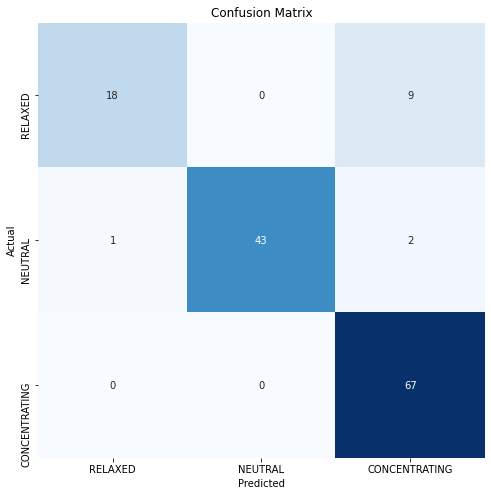

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.95      0.67      0.78        27
      NEUTRAL       1.00      0.93      0.97        46
CONCENTRATING       0.86      1.00      0.92        67

     accuracy                           0.91       140
    macro avg       0.94      0.87      0.89       140
 weighted avg       0.92      0.91      0.91       140



In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [30]:
model.save(os.getcwd() + '/saved_models/1246_gru_tested.h5')

### Testing the state with my dataset
7/11 - Not able to load the model on a different device

In [2]:
os.getcwd() + '/saved_models/1246_gru_tested.h5'

'/Users/andyko/Desktop/EEG_Classification/saved_models/1246_gru_tested.h5'

In [5]:
model = tf.keras.models.load_model(os.getcwd() + '/saved_models/1246_gru_tested.h5')
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported